In [17]:
# Standard Libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Scikit-learn
from sklearn.metrics import confusion_matrix
# Keras
from keras import Sequential, Model
from keras.layers import (Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, MaxPooling2D,AveragePooling2D, Dropout, Dense, Flatten)
from keras.callbacks import EarlyStopping

In [18]:
# Objects to hold pairs of images and masks
train_image_mask = {
    'images': [],
    'masks': []
}

test_image_mask = {
    'images': [],
    'masks': []
}

# Objects to hold pairs of images and labels
train_image_class = {
    'images': [],
    'labels': []
}

test_image_class = {
    'images': [],
    'labels': []
}

def load_image_mask(train_image_mask=None, test_image_mask=None, image_path=None, shape=256):
    """Generates image/mask pairs from the dataset.

    Args:
        train_image_mask (dict): Dictionary to store training images and masks.
        test_image_mask (dict): Dictionary to store testing images and masks.
        image_path (str): Path to the images and masks.
        shape (int): Size to resize images and masks.

    Returns:
        tuple: Updated dictionaries containing images and masks.
    """
    file_names = os.listdir(image_path)
    
    image_names = []
    mask_names = []
    partial_names = [fn.split(')')[0] for fn in file_names]
    
    partial_names = list(set(partial_names))
    
    for name in partial_names:
        image_names.append(name + ').png')
        mask_names.append(name + ')_mask.png')
        
    train_test_split_index = int(len(image_names) * 0.8)
    
    for i, image_name in enumerate(image_names):
        image = plt.imread(os.path.join(image_path, image_name))
        mask = plt.imread(os.path.join(image_path, mask_names[i]))
        
        image = cv2.resize(image, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        
        if i < train_test_split_index:
            train_image_mask['images'].append(image)
            train_image_mask['masks'].append(mask)
        else:
            test_image_mask['images'].append(image)
            test_image_mask['masks'].append(mask)
        
    return train_image_mask, test_image_mask

def load_image_class(train_image_class=None, test_image_class=None, image_path=None, shape=256):
    """Generates image/label pairs from the dataset.

    Args:
        train_image_class (dict): Dictionary to store training images and labels.
        test_image_class (dict): Dictionary to store testing images and labels.
        image_path (str): Path to the images.
        shape (int): Size to resize images.

    Returns:
        tuple: Updated dictionaries containing images and labels.
    """
    file_names = os.listdir(image_path)
    image_class = os.path.basename(image_path)
    
    image_names = [fn.split(')')[0] + ').png' for fn in file_names]
    
    train_test_split_index = int(len(image_names) * 0.8)
    
    for i, image_name in enumerate(image_names):
        image = plt.imread(os.path.join(image_path, image_name))
        image = cv2.resize(image, (shape, shape))
        
        if i < train_test_split_index:
            train_image_class['images'].append(image)
            train_image_class['labels'].append(image_class)
        else:
            test_image_class['images'].append(image)
            test_image_class['labels'].append(image_class)
        
    return train_image_class, test_image_class

In [19]:
from pathlib import Path

base_dir = Path("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT")
categories = ['normal', 'benign', 'malignant']

for category in categories:
    image_dir = base_dir / category / 'images'
    mask_dir = base_dir / category / 'masks'
    
    print(f"Checking directories for category '{category}':")
    print(f"Images directory: {image_dir}")
    print(f"Masks directory: {mask_dir}")

    if image_dir.exists():
        print("Images directory exists.")
        print(list(image_dir.iterdir()))  # List files in the images directory
    else:
        print(f"Error: Images directory {image_dir} does not exist.")

    if mask_dir.exists():
        print("Masks directory exists.")
        print(list(mask_dir.iterdir()))  # List files in the masks directory
    else:
        print(f"Error: Masks directory {mask_dir} does not exist.")


Checking directories for category 'normal':
Images directory: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/images
Masks directory: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/masks
Error: Images directory /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/images does not exist.
Error: Masks directory /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/masks does not exist.
Checking directories for category 'benign':
Images directory: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/images
Masks directory: /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/masks
Error: Images directory /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/images does not exist.
Error: Masks directory /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/masks does not exist.
Checking directories for categor

In [20]:
# Load Benign class images and masks
train_image_mask, test_image_mask = load_image_mask(
    train_image_mask=train_image_mask, 
    test_image_mask=test_image_mask, 
    image_path="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign"
)

train_image_class, test_image_class = load_image_class(
    train_image_class=train_image_class, 
    test_image_class=test_image_class, 
    image_path="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign"
)

# Load Malignant class images and masks
train_image_mask, test_image_mask = load_image_mask(
    train_image_mask=train_image_mask, 
    test_image_mask=test_image_mask, 
    image_path="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant"
)

train_image_class, test_image_class = load_image_class(
    train_image_class=train_image_class, 
    test_image_class=test_image_class, 
    image_path="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant"
)


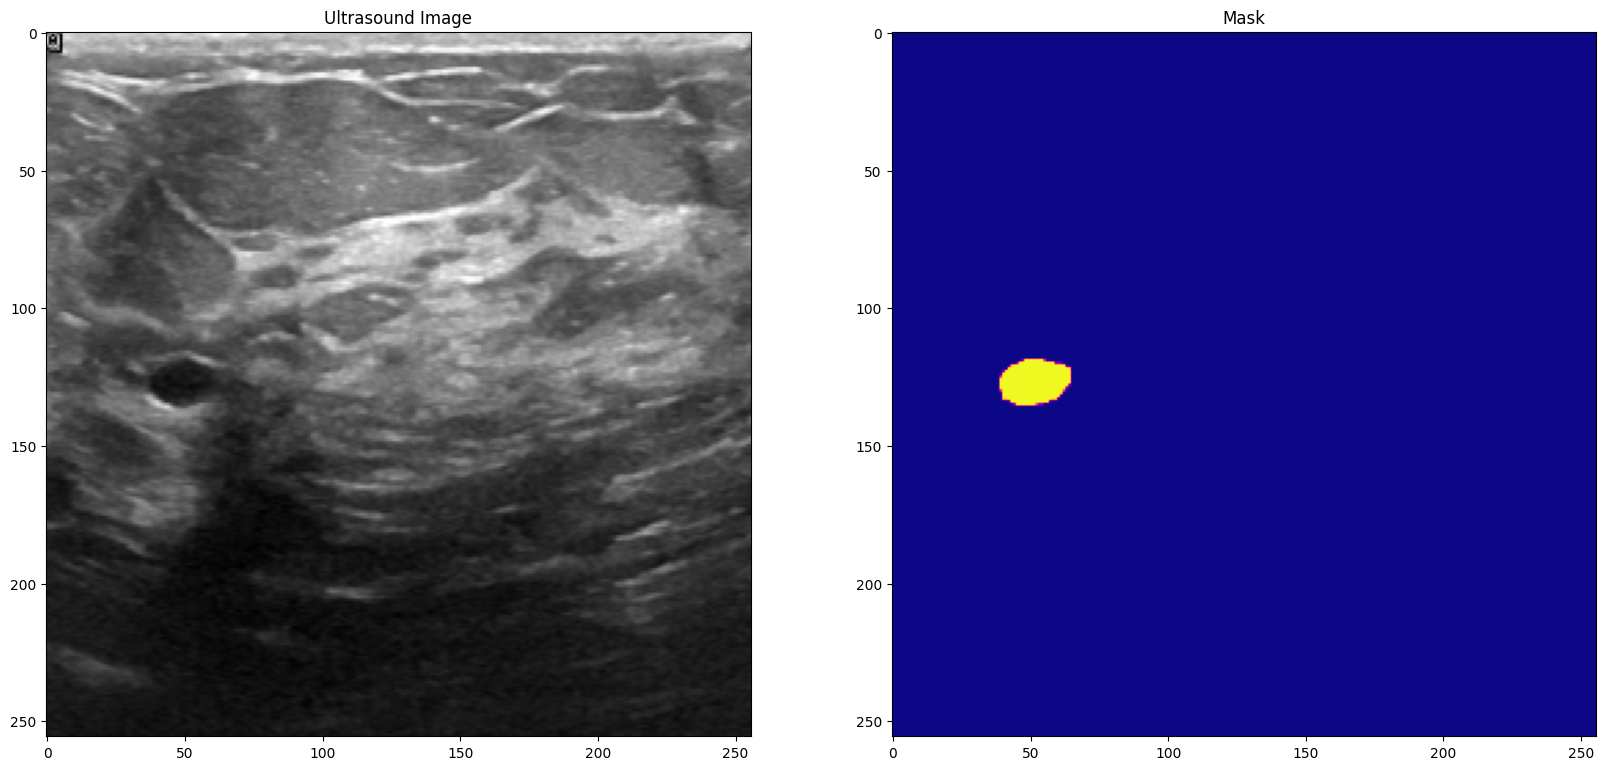

In [21]:
# Display one image/mask pair from the loaded dataset
plt.figure(figsize=(20, 20))

# Display the ultrasound image
plt.subplot(1, 2, 1)
plt.imshow(train_image_mask['images'][0])
plt.title('Ultrasound Image')

# Display the corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(train_image_mask['masks'][0], cmap='plasma')
plt.title('Mask')

plt.show()

In [22]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.models import Model

def convolutionBlock(inputTensor, filterCount, kernelSize=3):
    x = Conv2D(filters=filterCount, kernel_size=(kernelSize, kernelSize), kernel_initializer='he_normal', padding='same')(inputTensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=filterCount, kernel_size=(kernelSize, kernelSize), kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=filterCount, kernel_size=(kernelSize, kernelSize), kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def modelArchitecture(inputTensor, filterCount=16, dropoutRate=0.1):
    # Encoder
    conv1 = convolutionBlock(inputTensor, filterCount)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropoutRate)(pool1)
    
    conv2 = convolutionBlock(pool1, filterCount * 2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropoutRate)(pool2)
    
    conv3 = convolutionBlock(pool2, filterCount * 4)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropoutRate)(pool3)
    
    conv4 = convolutionBlock(pool3, filterCount * 8)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropoutRate)(pool4)
    
    conv5 = convolutionBlock(pool4, filterCount * 16)
    
    # Decoder
    up6 = Conv2DTranspose(filterCount * 8, (3, 3), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    up6 = Dropout(dropoutRate)(up6)
    conv6 = convolutionBlock(up6, filterCount * 8)
    
    up7 = Conv2DTranspose(filterCount * 4, (3, 3), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    up7 = Dropout(dropoutRate)(up7)
    conv7 = convolutionBlock(up7, filterCount * 4)
    
    up8 = Conv2DTranspose(filterCount * 2, (3, 3), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    up8 = Dropout(dropoutRate)(up8)
    conv8 = convolutionBlock(up8, filterCount * 2)
    
    up9 = Conv2DTranspose(filterCount, (3, 3), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    up9 = Dropout(dropoutRate)(up9)
    conv9 = convolutionBlock(up9, filterCount)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    segmentationModel = Model(inputs=[inputTensor], outputs=[outputs])
    
    return segmentationModel


In [23]:
# Initialization of the segmentation model
inputs = Input((256, 256, 3))

segmentationModel = modelArchitecture(inputs, dropoutRate = 0.2)
segmentationModel.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
segmentationModel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 256, 256,  │      2,320 │ activation_27[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 256, 256,  │      2,320 │ activation_28[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_29[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128, 128,  │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │      4,640 │ dropout_8[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_30[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_32[0][0] 

 Total params: 3,149,777 (12.02 MB)

 Trainable params: 3,145,361 (12.00 MB)

 Non-trainable params: 4,416 (17.25 KB)

In [24]:
history = segmentationModel.fit(
    np.array(train_image_mask['images']), 
    np.array(train_image_mask['masks']),
    epochs=75,
    validation_data=(
        np.array(test_image_mask['images']), 
        np.array(test_image_mask['masks'])
    ),
    callbacks=[
        EarlyStopping(
            patience=20, 
            monitor='val_loss', 
            mode='min', 
            restore_best_weights=True, 
            verbose=1
        )
    ]
)


Epoch 1/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4444 - loss: 0.7735 - val_accuracy: 0.1111 - val_loss: 13.9039
Epoch 2/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.8989 - loss: 0.4716 - val_accuracy: 0.8979 - val_loss: 0.4850
Epoch 3/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.9084 - loss: 0.4186 - val_accuracy: 0.7989 - val_loss: 0.5552
Epoch 4/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.9109 - loss: 0.3761 - val_accuracy: 0.8981 - val_loss: 0.4303
Epoch 5/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.9072 - loss: 0.3627 - val_accuracy: 0.6753 - val_loss: 3.6671
Epoch 6/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.9096 - loss: 0.3581 - val_accuracy: 0.8253 - val_loss: 0.4819
Epoch 7/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.9122 - loss: 0.3363 - val_accuracy: 0.8986 - val_loss: 0.3552
Epoch 8/75
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.9116 - loss: 0.3202 - val_accuracy: 0.8

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

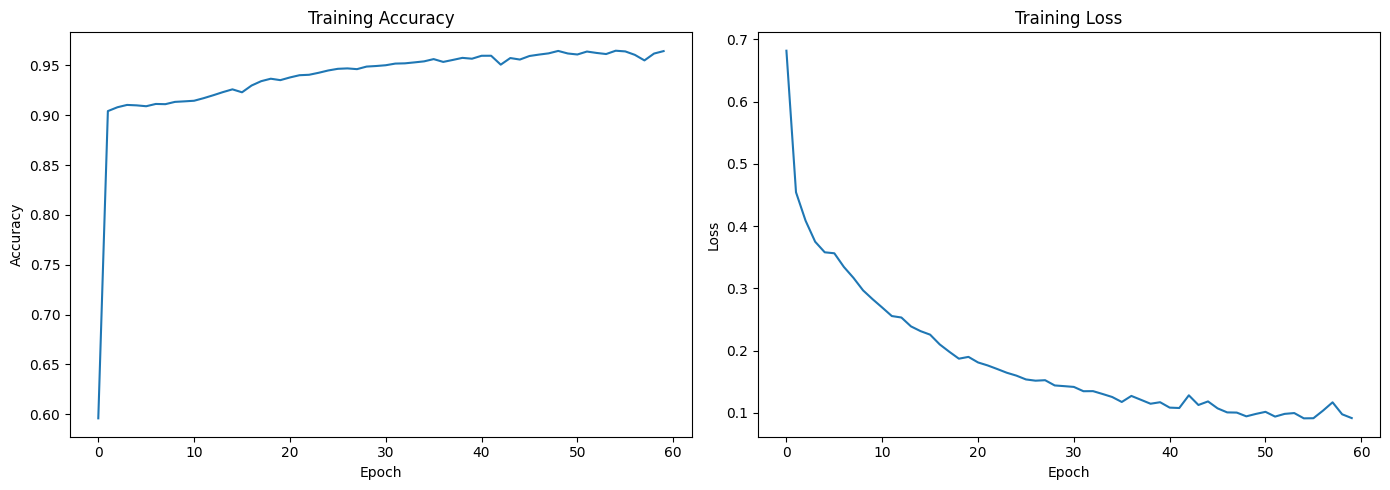

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))

# Convert accuracy and loss to a DataFrame for easier plotting with Seaborn
history_df = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': accuracy,
    'Loss': loss
})

# Create subplots to place the plots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training accuracy using Seaborn
sns.lineplot(data=history_df, x='Epoch', y='Accuracy', ax=axes[0])
axes[0].set_title('Training Accuracy')

# Plot training loss using Seaborn
sns.lineplot(data=history_df, x='Epoch', y='Loss', ax=axes[1])
axes[1].set_title('Training Loss')

# Display the plots
plt.tight_layout()
plt.show()


In [26]:
testImages = test_image_mask['images']
testMasks = test_image_mask['masks']

predictions = segmentationModel.predict(np.array(testImages))
print(predictions.shape)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step
(130, 256, 256, 1)


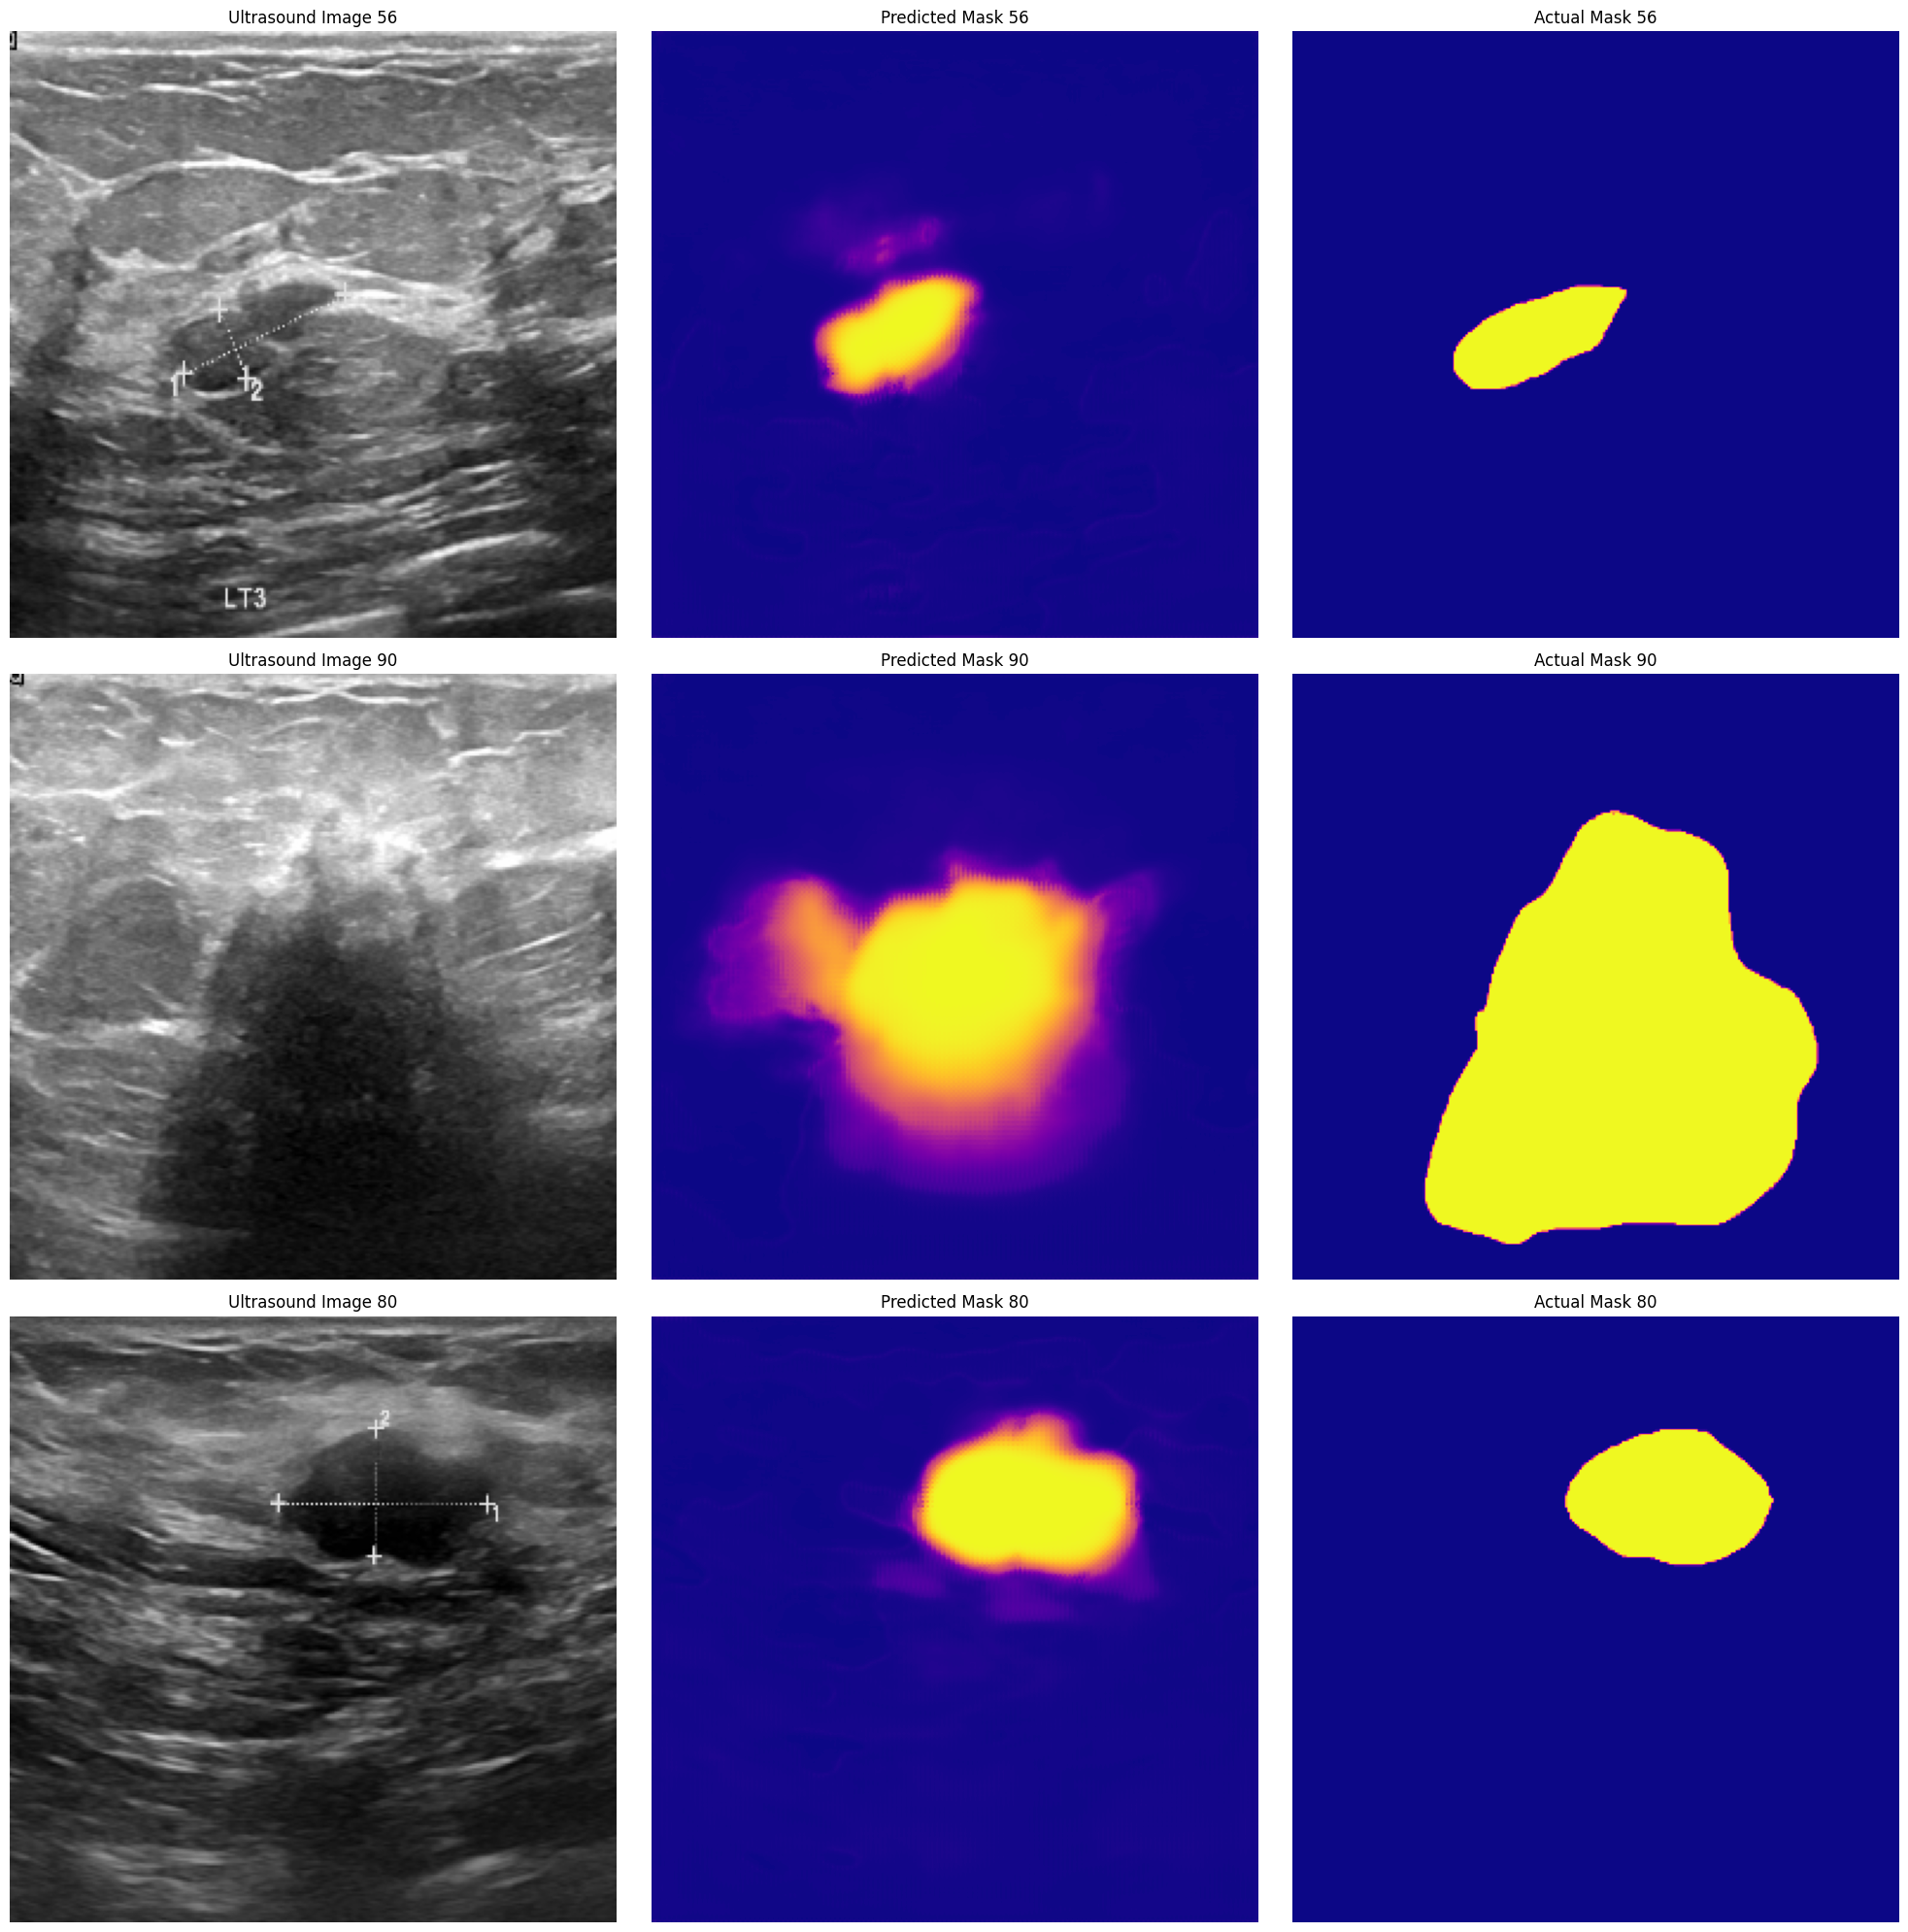

In [27]:
import matplotlib.pyplot as plt

# Define the indices for the images you want to plot
indices = [56, 90, 80]  # Modify these indices as needed

# Initialize the figure with a 3x3 grid
plt.figure(figsize=(20, 20))

# Loop over the indices and create subplots
for i, idx in enumerate(indices):
    # Determine the row and column for each image
    row = i // 3  # Row index (0 for the first row, 1 for the second row, etc.)
    col = i % 3   # Column index (0 for the first column, 1 for the second column, etc.)
    
    # Plot Ultrasound Image
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(testImages[idx])
    plt.title(f'Ultrasound Image {idx}')
    plt.axis('off')
    
    # Plot Predicted Mask
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(predictions[idx], cmap='plasma')
    plt.title(f'Predicted Mask {idx}')
    plt.axis('off')
    
    # Plot Actual Mask
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(testMasks[idx], cmap='plasma')
    plt.title(f'Actual Mask {idx}')
    plt.axis('off')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In [ ]:
segmentationModel.save('Breast Cancer Segmentation.h5')